
📊 EDA: Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null 

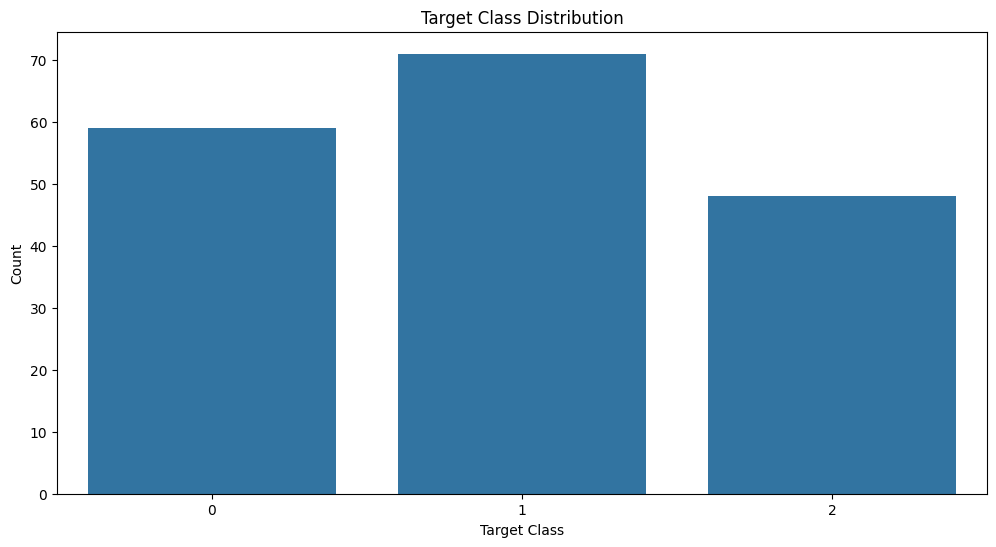


🔍 Quantum Circuit:
     ┌──────────────────────────┐┌────────────────────────────────────────────────────┐
q_0: ┤0                         ├┤0                                                   ├
     │  ZZFeatureMap(x[0],x[1]) ││  TwoLocal(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
q_1: ┤1                         ├┤1                                                   ├
     └──────────────────────────┘└────────────────────────────────────────────────────┘


C:\Users\Aravind\AppData\Local\Temp\ipykernel_21744\891536919.py:77: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(options={"shots": 1024})
C:\Users\Aravind\AppData\Local\Temp\ipykernel_21744\891536919.py:78: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(



🚀 Training Started...
Epoch 1/10 - Loss: 0.7209 | Output Range: 0.4245 to 0.4280
Epoch 10/10 - Loss: 0.7039 | Output Range: 0.4628 to 0.4655

✅ Test Accuracy: 0.5000

🧪 Sample Input: [2.38574752 0.33330878]
🧾 True Label: 0, Predicted: 0 (Confidence: 0.4679)


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit import QuantumCircuit
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Load dataset
wine = load_wine()
X, y = wine.data, wine.target
feature_names = wine.feature_names
target_names = wine.target_names

# 🔹 Added: Basic EDA
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print("\n📊 EDA: Dataset Info")
print(df.info())

print("\n📈 EDA: Target Value Counts")
print(df['target'].value_counts())

print("\n📌 EDA: Summary Statistics")
print(df.describe())

plt.figure(figsize=(12, 6))
sns.countplot(x='target', data=df)
plt.title('Target Class Distribution')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.show()

# 🔹 Keep only 2 classes for binary classification
X, y = X[y != 2], y[y != 2]

# Standardize and PCA
X_scaled = StandardScaler().fit_transform(X)
X_pca = PCA(n_components=2).fit_transform(X_scaled)
y_encoded = LabelEncoder().fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Quantum Circuit
num_qubits = 2
feature_map = ZZFeatureMap(feature_dimension=num_qubits)
ansatz = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', reps=3)
qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

print("\n🔍 Quantum Circuit:")
print(qc.draw(fold=100))

# QNN
estimator = Estimator(options={"shots": 1024})
qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator
)
qnn_layer = TorchConnector(qnn)

# Model
class QuantumClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.classical_pre = nn.Linear(2, 2)
        self.qnn = qnn_layer
        self.fc1 = nn.Linear(1, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 4)
        self.out = nn.Linear(4, 1)

    def forward(self, x):
        x = self.classical_pre(x)
        x = self.qnn(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.out(x)  # Raw logits

model = QuantumClassifier()

# Training
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()
epochs = 10

print("\n🚀 Training Started...")
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    with torch.no_grad():
        pred_probs = torch.sigmoid(outputs)
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss.item():.4f} | Output Range: {pred_probs.min().item():.4f} to {pred_probs.max().item():.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    test_logits = model(X_test_tensor)
    test_probs = torch.sigmoid(test_logits)
    predictions = (test_probs > 0.5).float()
    accuracy = (predictions == y_test_tensor).float().mean()
    print(f"\n✅ Test Accuracy: {accuracy:.4f}")

# 🔹 Sample Input Prediction
sample_input = X_test_tensor[0].unsqueeze(0)
sample_true = y_test_tensor[0].item()
with torch.no_grad():
    sample_output = model(sample_input)
    sample_prob = torch.sigmoid(sample_output).item()
    sample_pred = int(sample_prob > 0.5)
    print(f"\n🧪 Sample Input: {X_test[0]}")
    print(f"🧾 True Label: {int(sample_true)}, Predicted: {sample_pred} (Confidence: {sample_prob:.4f})")
